In [21]:
# Import requisite modules
import math
import operator
import logging
import traceback
import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import Qiskit packages
import qiskit
from qiskit_algorithms import SamplingVQE, QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# The data providers of stock-market data
from qiskit_finance.data_providers import BaseDataProvider
from qiskit_finance.applications.optimization import PortfolioDiversification
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_aer.primitives import Sampler

In [2]:
# This code is part of a Qiskit project.
#
# (C) Copyright IBM 2020, 2024.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

""" Yahoo data provider. """

from __future__ import annotations
import datetime
import logging
import tempfile
import yfinance as yf

logger = logging.getLogger(__name__)

# Sets Y!Finance cache path in a new temp folder.
# This is done to avoid race conditions in the same cache file
# from different processes.
# The path will be automatically deleted if this module unloads cleanly.
# This needs to be done during yfinance initialization before any call
_temp_dir = tempfile.TemporaryDirectory()  # pylint: disable=consider-using-with
yf.set_tz_cache_location(_temp_dir.name)


class YahooDataProvider(BaseDataProvider):
    """Yahoo data provider.

    This data provider retrieves stock market data from Yahoo Finance using the yfinance library.
    For more details on usage, please refer to the official documentation:
    https://qiskit-community.github.io/qiskit-finance/tutorials/11_time_series.html
    """

    def __init__(
        self,
        tickers: str | list[str] | None = None,
        start: datetime.datetime = datetime.datetime(2016, 1, 1),
        end: datetime.datetime = datetime.datetime(2016, 1, 30),
    ) -> None:
        """
        Initialize the Yahoo Data Provider.

        Args:
            tickers (str | list[str] | None): Tickers for the data provider.

                * If a string is provided, it can be a single ticker symbol or multiple symbols
                  separated by semicolons or newlines.
                * If a list of strings is provided, each string should be a single ticker symbol.

                Default is :code:`None`, which corresponds to no tickers provided.
            start (datetime.datetime): Start date of the data.
                Default is January 1st, 2016.
            end (datetime.datetime): End date of the data.
                Default is January 30th, 2016.
        """
        super().__init__()

        if tickers is None:
            tickers = []
        if isinstance(tickers, str):
            tickers = tickers.replace("\n", ";").split(";")

        self._tickers = tickers
        self._n = len(tickers)
        self._start = start.strftime("%Y-%m-%d")
        self._end = end.strftime("%Y-%m-%d")
        self._data = []

    def run(self) -> None:
        """
        Loads data from Yahoo Finance.

        This method retrieves stock market data from Yahoo Finance using the :code:`yfinance` library,
        and populates the data attribute of the base class, enabling further calculations like
        similarity and covariance matrices.

        Raises:
            QiskitFinanceError: If there are missing tickers in download,
                if accessing Yahoo Data fails, or if no data is found for
                the specified date range, possibly due to de-listed symbols.
        """
        if len(self._tickers) == 0:
            raise QiskitFinanceError("Missing tickers to download.")
        self._data = []
        stocks_notfound = []
        try:
            # Download multiple tickers in single thread to avoid
            # race condition
            stock_data = yf.download(
                self._tickers,
                start=self._start,
                end=self._end,
                group_by="ticker",
                threads=False,
                progress=logger.isEnabledFor(logging.DEBUG),
            )
            
            if len(self._tickers) == 1:
                ticker_name = self._tickers[0]
                stock_value = stock_data["Close"]

                if stock_value.dropna().empty:
                    stocks_notfound.append(ticker_name)

                self._data.append(stock_value)

            else:
                for ticker_name in self._tickers:
                    stock_value = stock_data[ticker_name]["Close"]

                    if stock_value.dropna().empty:
                        stocks_notfound.append(ticker_name)

                    self._data.append(stock_value)

        except Exception as ex:  # pylint: disable=broad-except
            logger.debug(ex, exc_info=True)
            raise QiskitFinanceError("Accessing Yahoo Data failed.") from ex

        if stocks_notfound:
            raise QiskitFinanceError(
                f"No data found for this date range, symbols may be de-listed: {stocks_notfound}."
            )


YF.download() has changed argument auto_adjust default to True


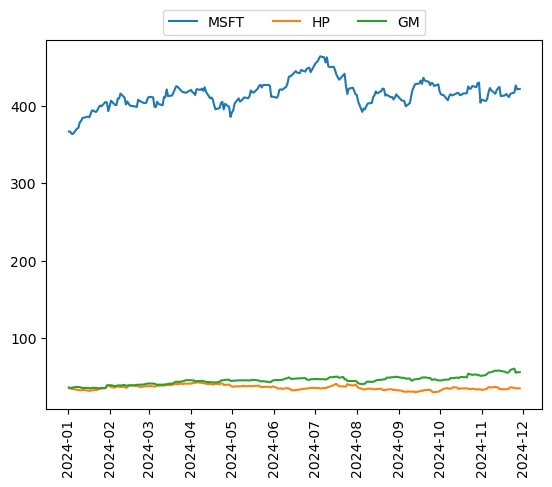

In [3]:
try:
    data = YahooDataProvider(
        tickers=["MSFT", "HP", "GM"],
        start=datetime.datetime(2024, 1, 1),
        end=datetime.datetime(2024, 11, 30),
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

In [15]:
rho = data.get_similarity_matrix()
n=3
algorithm_globals.massive=True

In [5]:
q = 2  # q less or equal than n

In [6]:
class ClassicalOptimizer:
    def __init__(self, rho, n, q):

        self.rho = rho
        self.n = n  # number of inner variables
        self.q = q  # number of required selection

    def compute_allowed_combinations(self):
        f = math.factorial
        return int(f(self.n) / f(self.q) / f(self.n - self.q))

    def cplex_solution(self):

        # refactoring
        rho = self.rho
        n = self.n
        q = self.q

        my_obj = list(rho.reshape(1, n**2)[0]) + [0.0 for x in range(0, n)]
        my_ub = [1 for x in range(0, n**2 + n)]
        my_lb = [0 for x in range(0, n**2 + n)]
        my_ctype = "".join(["I" for x in range(0, n**2 + n)])

        my_rhs = (
            [q]
            + [1 for x in range(0, n)]
            + [0 for x in range(0, n)]
            + [0.1 for x in range(0, n**2)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 1 + n)])
            + "".join(["E" for x in range(0, n)])
            + "".join(["L" for x in range(0, n**2)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        col = [x for x in range(n**2, n**2 + n)]
        coef = [1 for x in range(0, n)]
        rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        for ii in range(0, n):
            col = [ii * n + ii, n**2 + ii]
            coef = [1, -1]
            rows.append([col, coef])

        for ii in range(0, n):
            for jj in range(0, n):
                col = [ii * n + jj, n**2 + jj]
                coef = [1, -1]

                rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [16]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(rho, n, q)

# Compute the number of feasible solutions:
print("Number of feasible combinations= " + str(classical_optimizer.compute_allowed_combinations()))

# Compute the total number of possible combinations (feasible + unfeasible)
print("Total number of combinations= " + str(2 ** (n * (n + 1))))

Number of feasible combinations= 3
Total number of combinations= 4096


In [8]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.015, yc[i]), size=16, color="r")

    plt.grid()

    for ii in range(n**2, n**2 + n):

        if x[ii] > 0:
            plt.plot(xc[ii - n**2], yc[ii - n**2], "r*", ms=20)

    for ii in range(0, n**2):

        if x[ii] > 0:
            iy = ii // n
            ix = ii % n
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], "C2")

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

In [9]:
class QuantumOptimizer:
    def __init__(self, rho, n, q):
        self.rho = rho
        self.n = n
        self.q = q
        self.pdf = PortfolioDiversification(similarity_matrix=rho, num_assets=n, num_clusters=q)
        self.qp = self.pdf.to_quadratic_program()

    # Obtains the least eigenvalue of the Hamiltonian classically
    def exact_solution(self):
        exact_mes = NumPyMinimumEigensolver()
        exact_eigensolver = MinimumEigenOptimizer(exact_mes)
        result = exact_eigensolver.solve(self.qp)
        return self.decode_result(result)

    def sampling_vqe_solution(self):
        algorithm_globals.random_seed = 100
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        ry = TwoLocal(n, "ry", "cz", reps=5, entanglement="full")
        svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
        svqe = MinimumEigenOptimizer(svqe_mes)
        result = svqe.solve(self.qp)
        return self.decode_result(result)

    def qaoa_solution(self):
        algorithm_globals.random_seed = 1234
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(self.qp)
        return self.decode_result(result)

    def decode_result(self, result, offset=0):
        quantum_solution = 1 - (result.x)
        ground_level = self.qp.objective.evaluate(result.x)
        return quantum_solution, ground_level

In [17]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(rho, n, q)

In [27]:
# Check if the binary representation is correct. This requires CPLEX
try:
    import cplex

    # warnings.filterwarnings('ignore')
    quantum_solution, quantum_cost = quantum_optimizer.exact_solution()
    print(quantum_solution, quantum_cost)
    classical_cost = quantum_cost
    classical_solution, classical_cost = classical_optimizer.cplex_solution()
    print(classical_solution, classical_cost)
    if np.abs(quantum_cost - classical_cost) < 0.01:
        print("Binary formulation is correct")
    else:
        print("Error in the formulation of the Hamiltonian")
except Exception as ex:
    print(ex)

[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.] 2.0004899167984123
[1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.] 2.0000113721960124
Binary formulation is correct


In [28]:
ground_state, ground_level = quantum_optimizer.exact_solution()
print(ground_state, ground_level)

try:
    if np.abs(ground_level - classical_cost) < 0.01:
        print("Ising Hamiltonian in Z basis is correct")
    else:
        print("Error in the Ising Hamiltonian formulation")
except Exception as ex:
    print(ex)

[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.] 2.0004899167984123
Ising Hamiltonian in Z basis is correct


In [22]:
vqe_state, vqe_level = quantum_optimizer.sampling_vqe_solution()
print(vqe_state, vqe_level)

try:
    if np.linalg.norm(ground_state - vqe_state) < 0.01:
        print("VQE produces the same solution as the exact eigensolver.")
    else:
        print(
            "VQE does not produce the same solution as the exact eigensolver, but that is to be expected."
        )
except Exception as ex:
    print(ex)

C:\Users\markw\AppData\Local\Temp\ipykernel_42704\4200435552.py:1: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  vqe_state, vqe_level = quantum_optimizer.sampling_vqe_solution()


[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.] 2.0004899167984123
VQE produces the same solution as the exact eigensolver.


In [23]:
xc, yc = data.get_coordinates()

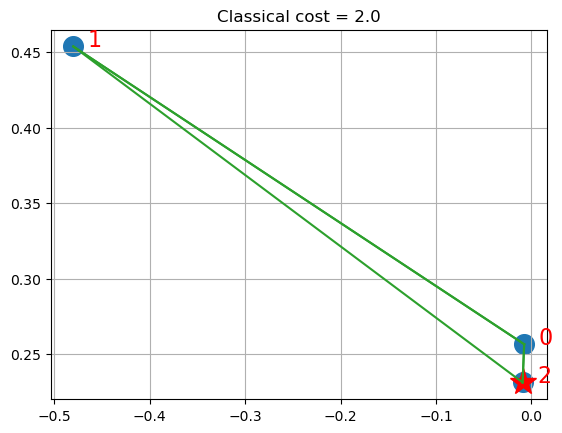

In [24]:
visualize_solution(xc, yc, ground_state, ground_level, n, q, "Classical")

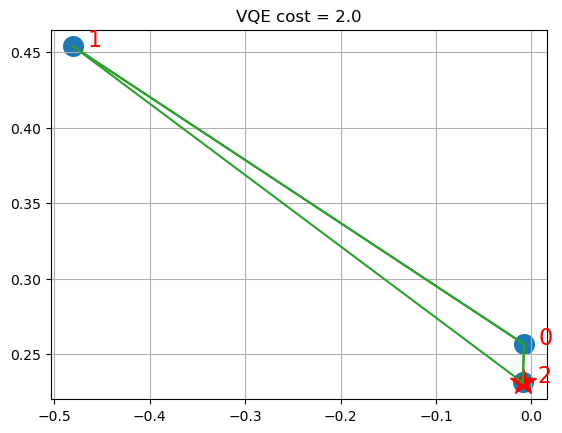

In [25]:
visualize_solution(xc, yc, vqe_state, vqe_level, n, q, "VQE")

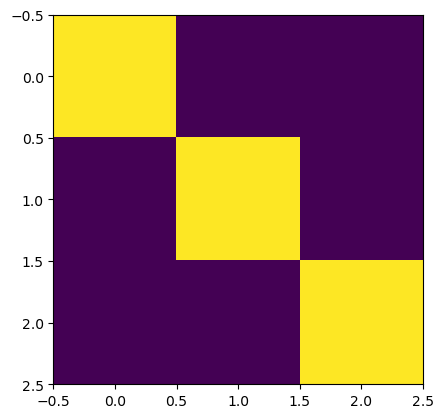

In [26]:
plt.imshow(rho)
plt.show()